# Line Tracing #

## Idea ##

Function: Main
1) Load 1 pixel Image
2) Give every pixel a id
3) Select a Starting Point
Function: Trace Line
1) Check all Pixels surrounding the Starting Point

In [220]:
import lib.utils as utils
#import classes
import matplotlib.pyplot as plt
import igraph as g
import json
import math as m
import cv2
import itertools
import json

from lib.utils import getPixel,colorPixels,isOneColor
from lib.constants import *

In [221]:
imageArray = utils.load1Pixel("./../resources/testImages","preprocessed1.png",binary=True)
colorImage = utils.load1Pixel("./../resources/testImages","preprocessed1.png",color=True)

end reached


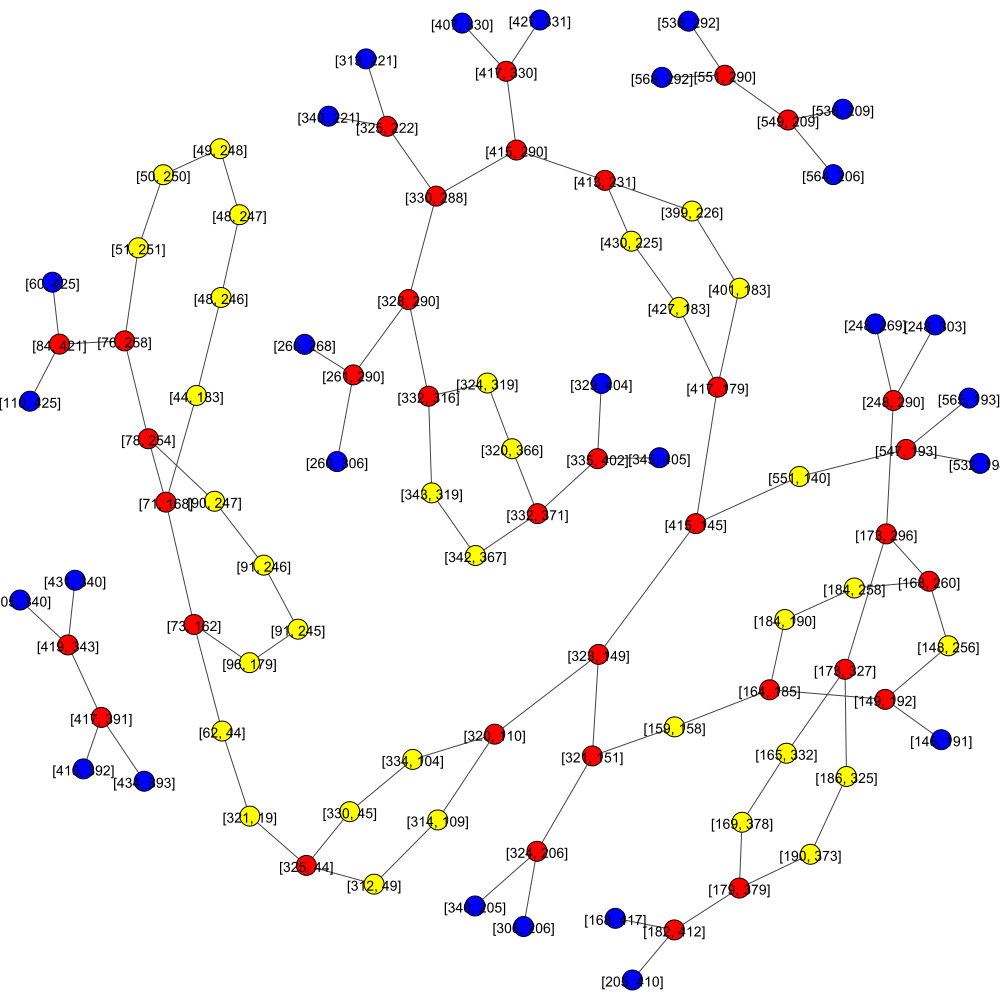

In [222]:
# Returns all Adjacent Pixels with a specific color
# image             -> 2D array with Pixel values
# pixel             -> coordinates of the pixel the others should be ajacent to
# color             -> the color of the "wanted" pixels
# blacklist         -> These pixels get ignored
def getAdjacentPixel(image,pixel,color,blacklist=[]):    
    adjacentPixels = [[-1,-1],[0,-1],[1,-1], \
                        [-1,0],        [1,0], \
                        [-1,1], [0,1], [1,1]]
    #create a array with the coordinates of all adjacentPixels
    validPixels = ([ pixel[0]+adj[0], pixel[1]+adj[1] ] for adj in adjacentPixels)
    #filter all pixels that are not the right color
    validPixels = list(
        filter(lambda coords: getPixel(image,coords) == color,validPixels)
    )
    #filter all pixels that are in the blacklist
    validPixels = list(
        filter(lambda x: not x in blacklist, validPixels)
    )

    return validPixels

# returns the coordinates of the first <color> pixel it finds
def findStaringPoint(image,color):
    for y in range(0,len(image)):
        for x in range(0,len(image[y])):
            if getPixel(image,x,y) == color:
                return [x,y]

# Runs along line until it finds the first Intersection
#
# image      -> The image
# startPoint -> Any random Point on the line
# color      -> The color of the Line
def findFirstIntersection(image,startPoint,color):

    def recursiveFindValidPoint(currentPixel,lastPixel,dir):
        adjacentPixels = getAdjacentPixel(image,currentPixel,color)
        if len(adjacentPixels) > 2:
            return currentPixel
        elif len(adjacentPixels) == 1:
            return recursiveFindValidPoint(adjacentPixels[dir],currentPixel,-1)
        else:
            adjacentPixels = getAdjacentPixel(image,currentPixel,color,[lastPixel]) 
            return recursiveFindValidPoint(adjacentPixels[dir],currentPixel,dir)
    return recursiveFindValidPoint(startPoint,None,0)

# Converts one connected Line into a Graph
#
# startPoint  -> coordinates of a Intersection
# color -> the color of the lines
# returns the generate graph and all visited Pixels
def generatePartGraph(image,startPoint,color):
    visitedPixels = []
    graph = g.Graph(directed=False)
    graph.add_vertex(str(startPoint), label=str(startPoint) ,color=INTERSECTION_COLOR)
    
    def recursiveGenerateGraph(currentPixel,lastPixel,lastGraphNode,dirGradientOld):
        dirGradient = list(dirGradientOld)

        #get Direction
        if(abs(currentPixel[0] - lastPixel[0]) < abs(currentPixel[1] - lastPixel[1])):
            dirGradient.append(1)
        else:
            dirGradient.append(0)

        #End Recursion if loop ends
        if currentPixel in visitedPixels:
            if len(graph.vs.select(name=str(currentPixel))):
                graph.add_edge(str(lastGraphNode),str(currentPixel))
            return

        visitedPixels.append(currentPixel)
        adjacentPixels = getAdjacentPixel(image,currentPixel,color,[lastPixel])
        if len(adjacentPixels) == 0:
            #ENDPOINT
            if(str(currentPixel) != lastGraphNode):
                graph.add_vertex(str(currentPixel),label=str(currentPixel),color=END_COLOR)
                graph.add_edge(str(lastGraphNode),str(currentPixel))
        elif len(adjacentPixels) == 1:
            #LINE
            if len(dirGradient) > 6:
                currDire = sum(dirGradient[-4:])/4 < 0.5
                lastDire = sum(dirGradient[-5:-1])/4 < 0.5
                if not  currDire == lastDire:
                    graph.add_vertex(str(currentPixel),label=str(currentPixel),color=CORNER_COLOR)
                    graph.add_edge(str(lastGraphNode),str(currentPixel))
                    recursiveGenerateGraph(adjacentPixels[0],currentPixel,str(currentPixel),dirGradient)
                else:
                    recursiveGenerateGraph(adjacentPixels[0],currentPixel,lastGraphNode,dirGradient)
            else:
                recursiveGenerateGraph(adjacentPixels[0],currentPixel,lastGraphNode,dirGradient)
        else:
            #INTERSECTION
            if(str(currentPixel) != lastGraphNode):
                graph.add_vertex(str(currentPixel),label=str(currentPixel),color=INTERSECTION_COLOR)
                graph.add_edge(str(lastGraphNode),str(currentPixel))
            for adjacentPixel in adjacentPixels:
                recursiveGenerateGraph(adjacentPixel,currentPixel,str(currentPixel),[])

    recursiveGenerateGraph(startPoint,[0,0],str(startPoint),[])
    return graph,visitedPixels


def generateWholeGraph(image,foregroundColor,backgroundColor):
    graphCollection = []
    while True:
        startingPoint = findStaringPoint(image,foregroundColor)
        if(startingPoint):
            startingPoint = findFirstIntersection(image,startingPoint,foregroundColor)
            G,visitedPixels = generatePartGraph(image,startingPoint,foregroundColor)
            graphCollection.append(G)
            #Remove all visited Pixels
            image = colorPixels(image,visitedPixels,backgroundColor)
            if isOneColor(image,backgroundColor):
                print("end reached")
                break
        else:
            print("stoped before end")
            break

    return g.union(graphCollection)

union = generateWholeGraph(imageArray,FOREGROUND,BACKGROUND)

layout = union.layout("fr")
g.plot(union, layout=layout,bbox = (1000,1000))

#### Pattern detection

In [223]:
def groundPattern():
    ground = g.Graph(directed=False)
    ground.add_vertex(0,color="blue")
    ground.add_vertex(1,color="red")
    ground.add_vertex(2,color="blue")
    ground.add_edge(1,0)
    ground.add_edge(1,2)
    return ground

def getColorListNode(graph):
    colorList = []
    for vert in graph.vs:
        if vert["color"] == "red":
            colorList.append(0)
        elif vert["color"] == "blue":
            colorList.append(1)
        elif vert["color"] == "yellow":
            colorList.append(2)
        elif vert["color"] == "white":
            colorList.append(3)
    return colorList

def getColorListEdge(graph):
    colorList = []
    for edge in graph.es:
        try:
            if edge["color"] == "red":
                colorList.append(1)
            elif edge["color"] == "blue":
                colorList.append(2)
            elif edge["color"] == "yellow":
                colorList.append(3)
            elif edge["color"] == "white":
                colorList.append(4)
            elif edge["color"] == "green":
                colorList.append(5)
            else:
                colorList.append(0)
        except:
            colorList.append(0)
    return colorList

def getPatternMatches(graph,pattern):
    mapings = graph.get_subisomorphisms_vf2(pattern,color1=getColorListNode(graph),color2=getColorListNode(pattern),edge_color1=getColorListEdge(graph),edge_color2=getColorListEdge(pattern))
    result = []
    for i in range(0,len(mapings)):
        # Get all the coordinates of the Notes that match the pattern
        result.append(list( map(lambda node:json.loads(graph.vs.find(node)["label"]) ,mapings[i]) ))

    #result is a 2D array [List of Matched Patterns] [[List of Coordinates that match]]
    #Sort the List of Coorinates that match, in order to remove doubles
    for i in range(0,len(result)):
        result[i] = list(sorted(result[i]))
    #remove duplicated
    final = []
    for i in result:
        if i not in final:
            final.append(i)
    return final

def connectCapsTogehter(graph):
    ground = groundPattern()

    # Match all ground Symbols
    groundMatches = getPatternMatches(graph,ground)

    up =[]
    down = []
    left = []
    right = []

    for match in groundMatches:
        intersection = list(filter(lambda x: graph.vs.select(name=str(x))['color'][0] == INTERSECTION_COLOR, match))
        graph.vs.find(name_eq=str(intersection[0])).index
        neighbors = graph.neighbors(graph.vs.find(name_eq=str(intersection[0])))
        intersection[0]
        for n in neighbors:
            if not graph.vs[n]['color'] == 'blue':
                xOff = intersection[0][0] - json.loads(graph.vs[n]['name'])[0]
                yOff = intersection[0][1] - json.loads(graph.vs[n]['name'])[1]

                if abs(xOff) > abs(yOff):
                    if xOff > 0:
                        left.append(intersection[0])
                    else:
                        right.append(intersection[0])
                else:
                    if yOff > 0:
                        up.append(intersection[0])
                    else:
                        down.append(intersection[0])
                break

    for lCap in left:
        min = m.sqrt((lCap[0] - right[0][0])**2 + (lCap[1] - right[0][1])**2)
        minCap = right[0]
        for rCap in right:
            dist = m.sqrt((lCap[0] - rCap[0])**2 + (lCap[1] - rCap[1])**2)
            if dist < min and graph.shortest_paths_dijkstra(source=str(lCap), target = str(minCap), mode="all")[0][0] != 1:
                min = dist
                minCap = rCap
        graph.vs.select(name=str(lCap))['color'] = OTHER_NODE_COLOR
        graph.vs.select(name=str(minCap))['color'] = OTHER_NODE_COLOR
        graph.add_edge(str(lCap),str(minCap),color=OTHER_EDGE_COLOR)

    for dCap in down:
        min = m.sqrt((dCap[0] - up[0][0])**2 + (dCap[1] - up[0][1])**2)
        minCap = up[0]
        for uCap in up:
            dist = m.sqrt((dCap[0] - uCap[0])**2 + (dCap[1] - uCap[1])**2)
            if dist < min and graph.shortest_paths_dijkstra(source=str(dCap), target = str(minCap), mode="all")[0][0] != 1:
                min = dist
                minCap = uCap
        graph.vs.select(name=str(dCap))['color'] = OTHER_NODE_COLOR
        graph.vs.select(name=str(minCap))['color'] = OTHER_NODE_COLOR
        graph.add_edge(str(dCap),str(minCap),color=OTHER_EDGE_COLOR)


    #now calculate the distance between each and every ground
    #create parinings (permutations without order) example: [1,2,3] -> [1,2],[2,3],[1,3]
    #combintations = list(itertools.combinations(groundMatches,2))
    ##for every combination
    #for combination in combintations:
    #    #check distance between two red nodes of the Ground symbol      (End)--(Center/Intersection)--(End)
#
    #    #get Intersection node in every combination
    #    redOne = list(filter(lambda x: graph.vs.select(name=str(x))['color'][0] == INTERSECTION_COLOR,combination[0]))
    #    redTwo = list(filter(lambda x: graph.vs.select(name=str(x))['color'][0] == INTERSECTION_COLOR,combination[1]))
    #    if len(redOne)== 1 and len(redTwo) == 1 and redOne != redTwo:
    #        redOne = redOne[0]
    #        redTwo = redTwo[0]
    #        #check distance between the two
    #        if m.sqrt((redOne[0] - redTwo[0])**2 + (redOne[1] - redTwo[1])**2) < 25:
    #            #only if the two are not directly connected
    #            numberOfNodesBetween = graph.shortest_paths_dijkstra(source=str(redOne), target = str(redTwo), mode="all")[0][0]
    #            if not numberOfNodesBetween == 1:
    #                graph.vs.select(name=str(redOne))['color'] = OTHER_NODE_COLOR
    #                graph.vs.select(name=str(redTwo))['color'] = OTHER_NODE_COLOR
    #                graph.add_edge(str(redOne),str(redTwo),color=OTHER_EDGE_COLOR)
    return graph



def capPattern():
    cap = g.Graph(directed=False)
    cap.add_vertex(0,color="blue")
    cap.add_vertex(1,color="white")
    cap.add_vertex(2,color="blue")
    cap.add_edge(1,0)
    cap.add_edge(1,2)

    cap.add_vertex(3,color="blue")
    cap.add_vertex(4,color="white")
    cap.add_vertex(5,color="blue")
    cap.add_edge(4,3)
    cap.add_edge(4,5)

    cap.add_edge(1,4, color="green")
    return cap

def resistorPattern():
    res = g.Graph(directed=False)
    res.add_vertex(0,color="red")
    res.add_vertex(1,color="yellow")
    res.add_vertex(2,color="yellow")
    res.add_vertex(3,color="red")
    res.add_vertex(4,color="yellow")
    res.add_vertex(5,color="yellow")
    res.add_edge(0,1)
    res.add_edge(1,2)
    res.add_edge(2,3)
    res.add_edge(3,4)
    res.add_edge(4,5)
    res.add_edge(5,0)
    return res

def generateBoundingBox(listOfCoords,offset):
    xCoords = list(map(lambda x: x[0],listOfCoords))
    yCoords = list(map(lambda y: y[1],listOfCoords))

    #get smalles and biggest of each and create Box
    from_ = [min(xCoords)-offset,min(yCoords)-offset]
    to_ = [max(xCoords)+offset,max(yCoords)+offset]
    return [from_,to_]


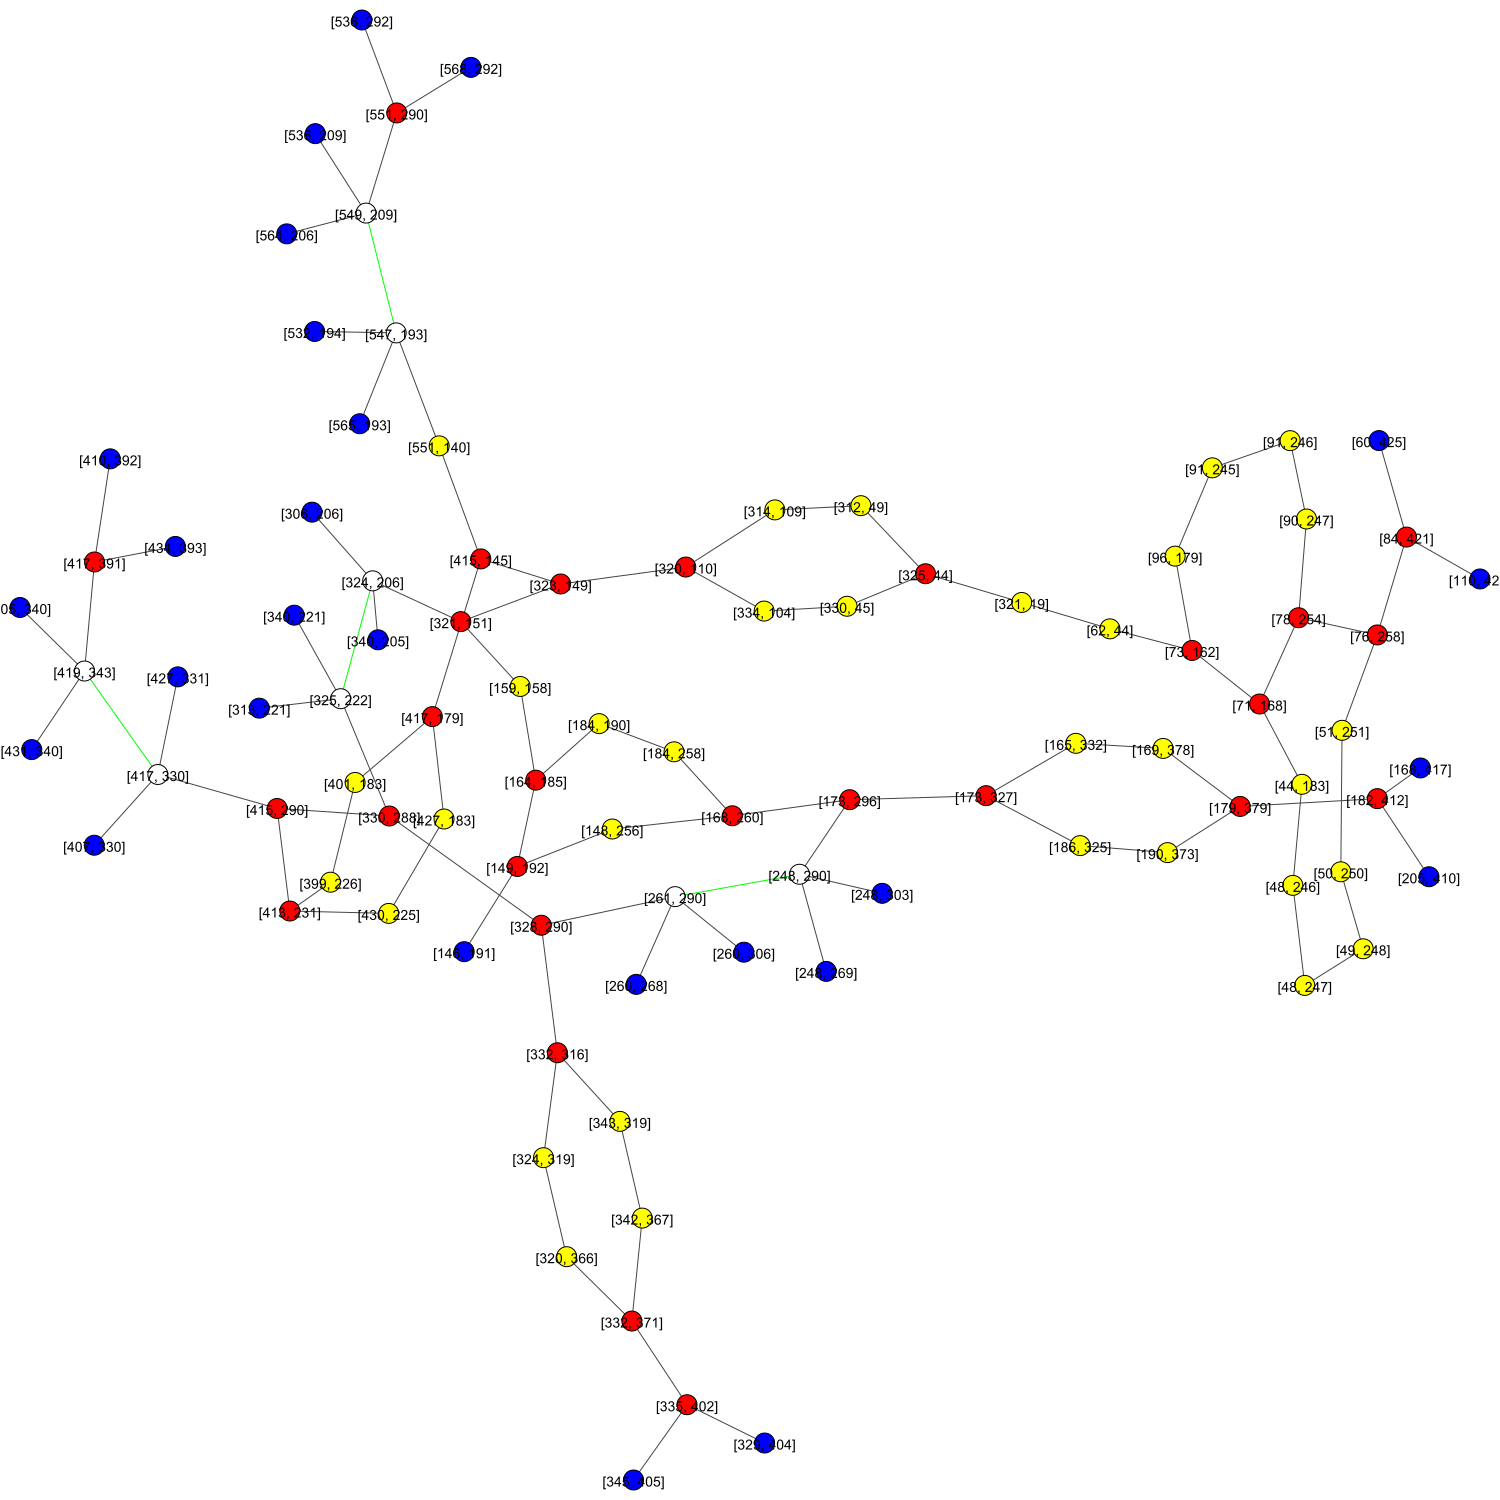

In [224]:
union = connectCapsTogehter(union)
layout = union.layout("large_graph")
g.plot(union, layout=layout,bbox=(1500, 1500))

[[[527, 188], [570, 214]], [[301, 200], [345, 227]], [[243, 263], [266, 311]], [[400, 325], [436, 348]], [[160, 320], [195, 384]], [[315, 311], [348, 376]], [[307, 39], [339, 115]], [[394, 174], [435, 236]], [[531, 285], [573, 297]], [[55, 416], [115, 430]], [[163, 405], [210, 422]], [[405, 386], [439, 398]], [[324, 397], [350, 410]]]


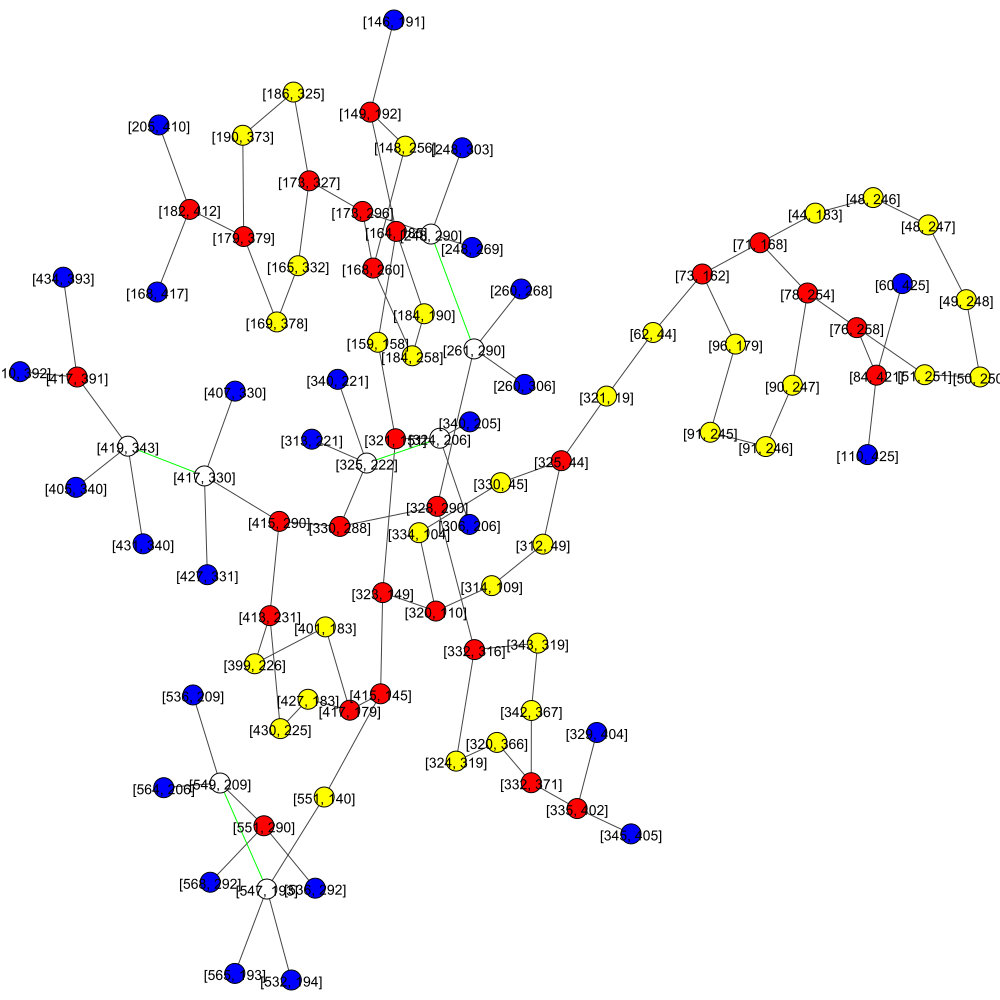

In [225]:
matches = getPatternMatches(union,capPattern()) + getPatternMatches(union,resistorPattern()) + getPatternMatches(union,groundPattern())
boundingBoxes = list(map(lambda x: generateBoundingBox(x,5),matches))
print(boundingBoxes)


layout = union.layout("large_graph")
g.plot(union, layout=layout,bbox=(1000, 1000))

#fig, ax = plt.subplots()
#g.plot(union, layout=layout, target=ax,bbox=(300, 300))

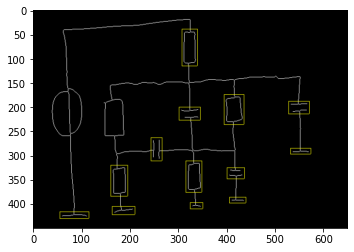

In [226]:
def drawRect(image,boundingBoxes,color):
    corner1 = boundingBoxes[0]
    corner2 = boundingBoxes[1]
    startX = corner1[0]
    startY = corner1[1]

    endX = corner2[0]
    endY = corner2[1]

    for x in range(startX,endX):
        image[startY][x] = color
        image[endY][x] = color

    for y in range(startY,endY):
        image[y][startX] = color
        image[y][endX] = color

    return image


for boundingBox in boundingBoxes:
    drawRect(colorImage,boundingBox,(255,0,0))
colorImage = cv2.cvtColor(255-colorImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorImage,interpolation="bilinear")